训练模型：

该部分说明了如何使用训练脚本 train.py 来训练一个分割模型。以下是可用的可选参数和示例：

###### --model MODEL：选择要使用的模型类型，可以是 "unet"、"fast_fcn"、"gated_scnn" 或 "deeplabv3plus"。
###### --ignore-class IGNORE_CLASS：指定要忽略的类别编号，默认为 255。
###### --patience PATIENCE：设置等待验证损失增加的轮数，默认为 5。
###### --base-lr BASE_LR：设置初始学习率。在验证损失停止增加的情况下，会重新加载最佳模型点，并将学习率除以 10 进行微调。默认为 1.0e-4。
###### --box-loss：如果设置了这个标志，将在损失计算中使用边界框回归损失。
###### --dataset DATASET：指定数据集，可以是 "dad" 或 "publaynet"。
###### --dataset-dir DATASET_DIR：指定数据集的根文件夹。
###### --img-size IMG_SIZE：训练图像的输入尺寸，默认为 512。
###### --batch-size BATCH_SIZE：数据集的批量大小，默认为 8。
###### --seed SEED：用于所有随机函数的种子，默认为 45。


Example
python ./train.py --model unet \
--ignore-class 255 \
--patience 5 \
--base-lr 0.0001 \
--box-loss \
--dataset dad \
--dataset-dir ./dad 
--img-size 512 \
--batch-size 16 \
--seed 42

In [2]:
#trian
!python train.py --model unet \
--ignore-class 255 \
--patience 5 \
--base-lr 0.0001 \
--box-loss \
--dataset dad \
--dataset-dir ./dad \
--img-size 512 \
--batch-size 16 \
--seed 42







2023-08-13 18:21:03.396103: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-13 18:21:04.590178: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 27639 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:18:00.0, compute capability: 8.6
Building dataset...

Running full mask generation, this may take a bit.
Building model...

Starting train loop...

2023-08-13 18:32:46.892420: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-08-13 18:32:59.140850: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2023-08-13 18:33:0

In [1]:
#检查tensorflow是否可以成功调用GPU
import tensorflow as tf

# 检查 TensorFlow 是否编译支持 CUDA
if tf.test.is_built_with_cuda():
    print("TensorFlow was built with CUDA support")
else:
    print("TensorFlow was not built with CUDA support")

# 查看 GPU 设备名称
gpu_device_name = tf.test.gpu_device_name()
if gpu_device_name:
    print("GPU device name:", gpu_device_name)
else:
    print("No GPU device found")







TensorFlow was built with CUDA support
GPU device name: /device:GPU:0


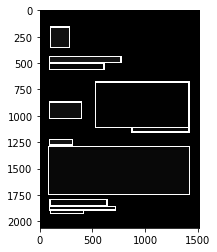

In [3]:
import matplotlib.pyplot as plt #matplotlib 内嵌了colormap（颜色映射）
from matplotlib.image import imread
import matplotlib.pyplot as plt
from matplotlib.image import imread
#pd.set_option('display.max_rows', None)#显示全
img = imread('/home/chenr/cr_work/layout_cr/DAD_Document_Layout_Segmentation/dad/masks/ELS_ENG_IJES_2011_V49_1/ELS_ENG_IJES_2011_V49_1-1.png')
plt.imshow(img)
plt.show()

In [1]:
# data pre xml to json
# 将知网数据的xml标注格式换成dad数据同样格式的json
import json
import os
import xml.etree.ElementTree as ET

def convert_xml_to_json(xml_path, label_mapping, group_id_mapping):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    xml_filename = os.path.splitext(os.path.basename(xml_path))[0]
    json_data = {
        "imagePath": "/home/chenr/cr_work/data/cnki_data/cnki_images/" + xml_filename + ".jpg",  # Change this line
        "imageData": None,
        "shapes": [],
        "version": "4.2.10",
        "flags": {},
        "imageHeight": int(root.find("size/height").text),
        "imageWidth": int(root.find("size/width").text)
    }

    for obj in root.findall("object"):
        label = obj.find("name").text
        label = label_mapping.get(label, label)
        points = [
            [int(obj.find("bndbox/xmin").text), int(obj.find("bndbox/ymin").text)],
            [int(obj.find("bndbox/xmax").text), int(obj.find("bndbox/ymax").text)]
        ]

        group_id = group_id_mapping.get(label, 0)  # Use the mapping for group_id

        shape = {
            "shape_type": "rectangle",
            "points": points,
            "flags": {},
            "group_id": group_id,
            "label": label
        }
        json_data["shapes"].append(shape)

    return json_data

# Specify the path to your XML folder
xml_folder = "/home/chenr/cr_work/data/cnki_data/20191210-30394xml/cnki_xml/"

# Specify the output folder for JSON files
output_folder = "/home/chenr/cr_work/data/cnki_data/cnki_data_json/"

# Define label and group_id mappings
label_mapping = {
    "text": "core_text",
    "footer": "core_text",
    "header": "core_text",
    "caption": "caption",
    "table": "table",
    "table1": "table",
    "table2": "table",
    "table3": "table",
    "figure": "figure",
    "equation": "math_formula"
    # Add more label mappings as needed
}

group_id_mapping = {
    "core_text": 19,
    "caption": 13,
    "table": 40,
    "figure": 25,
    "math_formula": 32
}

# Process each XML file in the folder
for xml_file in os.listdir(xml_folder):
    if xml_file.endswith(".xml"):
        xml_path = os.path.join(xml_folder, xml_file)
        json_data = convert_xml_to_json(xml_path, label_mapping, group_id_mapping)

        # Generate the output JSON file path based on the XML file name
        json_file_name = os.path.splitext(xml_file)[0] + ".json"
        json_file_path = os.path.join(output_folder, json_file_name)

        # Write JSON data to the output file
        with open(json_file_path, "w") as json_file:
            json.dump(json_data, json_file, indent=4)

        print(f"Converted {xml_file} to {json_file_name}")


Converted 1708QB04080_page238.xml to 1708QB04080_page238.json
Converted 1708QB04794_page48.xml to 1708QB04794_page48.json
Converted 1708OP00723_page66.xml to 1708OP00723_page66.json
Converted 1709OP00607_page79.xml to 1709OP00607_page79.json
Converted 1710QT00097_page75.xml to 1710QT00097_page75.json
Converted 1710QB00023_page81.xml to 1710QB00023_page81.json
Converted 1710OP00342_page343.xml to 1710OP00342_page343.json
Converted 1708OP00744_page13.xml to 1708OP00744_page13.json
Converted 1708QB02849_page54.xml to 1708QB02849_page54.json
Converted 1710QB02654_page101.xml to 1710QB02654_page101.json
Converted 1708QB00757_page138.xml to 1708QB00757_page138.json
Converted 1708OP02168_page105.xml to 1708OP02168_page105.json
Converted 1709OP01893_page79.xml to 1709OP01893_page79.json
Converted 1708QB01631_page58.xml to 1708QB01631_page58.json
Converted 1709OP02282_page70.xml to 1709OP02282_page70.json
Converted 1709QB05441_page12.xml to 1709QB05441_page12.json
Converted 1710QB00034_page76.x